## Imports 

In [1]:
import sys
import scipy
import numpy
import matplotlib
import pandas
import sklearn
from numbers import Number
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import math
import seaborn

In [2]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

In [3]:
dtype_obj = {
    'Health Service Area': str,
    'Hospital County': str,
    'Operating Certificate Number': str,
    'Facility ID': str,
    'Facility Name': str,
    'Age Group': str,
    'Zip Code - 3 digits': str,
    'Gender': str,
    'Race': str,
    'Ethnicity': str,
    'Length of Stay': int,
    'Type of Admission': str,
    'Patient Disposition': str,
    'Discharge Year': int,
    'CCS Diagnosis Code': str,
    'CCS Diagnosis Description': str,
    'CCS Procedure Code': str,
    'CCS Procedure Description': str,
    'APR DRG Code': str,
    'APR DRG Description': str,
    'APR MDC Code': str,
    'APR MDC Description': str,
    'APR Severity of Illness Code': str,
    'APR Severity of Illness Description': str,
    'APR Risk of Mortality': str,
    'APR Medical Surgical Description': str,
    'Source of Payment 1': str,
    'Source of Payment 2': str,
    'Source of Payment 3': str,
    'Attending Provider License Number': str,
    'Operating Provider License Number': str,
    'Other Provider License Number': str,
    'Birth Weight': float,
    'Abortion Edit Indicator': str,
    'Emergency Department Indicator': str,
    'Total Charges': float,
    'Total Costs': float,
    'year': int,
    'Hospital Service Area': str,
    'Permanent Facility Id': str,
    'Payment Typology 1': str,
    'Payment Typology 2': str,
    'Payment Typology 3': str
}

In [4]:
def changeIndexNames(key):
    return key.lower().replace(" ","_").replace("3", "three").replace("-","")
index_obj = {k: changeIndexNames(k) for k, v in dtype_obj.items()}

In [5]:
f2009 = pandas.read_csv("./data/raw_data/CD_2009.csv")
f2010 = pandas.read_csv("./data/raw_data/CD_2010.csv")
f2011 = pandas.read_csv("./data/raw_data/CD_2011.csv")
f2012 = pandas.read_csv("./data/raw_data/CD_2012.csv")
f2013 = pandas.read_csv("./data/raw_data/CD_2013.csv")
f2014 = pandas.read_csv("./data/raw_data/CD_2014.csv")
f2015 = pandas.read_csv("./data/raw_data/CD_2015.csv")
f2016 = pandas.read_csv("./data/raw_data/CD_2016.csv")

arry = [f2009,f2010,f2011,f2012,f2013,f2014,f2015,f2016]
start = 2009

In [6]:
for elem in arry:
    elem['year']=start
    start= start + 1

data = pandas.concat(arry, sort=False)

data.shape

(53117, 45)

In [8]:
# Data Cleanup operations:
data.at[data['Length of Stay'] == '120 +', 'Length of Stay']=120
data=data.drop(['Unnamed: 37','Ratio of Total Costs to Total Charges'], axis=1)

In [9]:
data = data.astype(dtype_obj)

In [10]:
data = data.rename(columns=index_obj)

In [11]:
for col in list(data):
    if data[col].nunique() == 1:
        data=data.drop([col], axis=1)

In [12]:
data.shape

(53117, 43)

In [13]:
data.dtypes

health_service_area                     object
hospital_county                         object
operating_certificate_number            object
facility_id                             object
facility_name                           object
age_group                               object
zip_code__three_digits                  object
gender                                  object
race                                    object
ethnicity                               object
length_of_stay                           int32
type_of_admission                       object
patient_disposition                     object
discharge_year                           int32
ccs_diagnosis_code                      object
ccs_diagnosis_description               object
ccs_procedure_code                      object
ccs_procedure_description               object
apr_drg_code                            object
apr_drg_description                     object
apr_mdc_code                            object
apr_mdc_descr

In [14]:
# In keeping with the NYS prevention agenda focus areas,
# we would like to hone in on chronic diseases to begin with
# e.g., cardiovascular events, hypertension, diabetes, respiratory
# illnesses such as asthma and chronic obstructive pulmonary disease (COPD),
# cancers - breast, colorectal and cervical) and mental health 
# e.g., schizophrenia, mood disorders etc) and also see distribution related
# to age, race and gender.

## Data Manipulation Workflow

In [15]:
# APR DRG Codes of interest; sourced from https://www.health.ny.gov
# /facilities/hospital/reimbursement/apr-drg/weights
# /2018-07-01_final_weights.htm
diag_cardio = ['22','160','161','162','163','165','166','167','170','171','174','175','176','177',
               '190','191','192','193','194','196','198','200',' 201','204','205','206']
diag_circ = ['24','45','46','47','169','180','181','182','197','199','207','246','651','660','661',
             '662','663']
diag_canc = ['41','44','136','240','281','382','442','461','500','511','512519','530','690','691',
             '692','694','695','696']
diag_resp = ['90','93','120','121','130','131','132','133','134','139','140','141','142','143','144']
diag_diab = ['420']
diag_ment = ['740','750','751','752','753','754','755','756','758','759','760']
diag_drug = ['280','770','772','773','774','775','776']
diag_neuro = ['23','26','40','42','43','48','52','53','54','58']
diag_infect = ['49','50','51','80','113','137','138','244','248','249','463','531','710','711','720',
               '721','723','724','890','892','893','894']
diag_trauma = ['20','55','56','57','135','469','910','911','912','930']

In [16]:
#Data Processing variables
crd = data['apr_drg_code'].isin(diag_cardio)
crc = data['apr_drg_code'].isin(diag_circ)
cnc = data['apr_drg_code'].isin(diag_canc)
rsp = data['apr_drg_code'].isin(diag_resp)
dbt = data['apr_drg_code'].isin(diag_diab)
mnt = data['apr_drg_code'].isin(diag_ment)
drg = data['apr_drg_code'].isin(diag_drug)
nrl = data['apr_drg_code'].isin(diag_neuro)
inf = data['apr_drg_code'].isin(diag_infect)
trm = data['apr_drg_code'].isin(diag_trauma)

In [17]:
# Add a diagnosis type column
data['diagnosis']=numpy.where(crd,"Cardiology",
                  numpy.where(crc,"Circulatory",
                  numpy.where(cnc,"Cancer",
                  numpy.where(rsp,"Respiratory",
                  numpy.where(dbt,"Diabetes",
                  numpy.where(mnt,"Metal Health",
                  numpy.where(drg,"Drug Issue",
                  numpy.where(nrl,"Neurological",
                  numpy.where(inf,"Infection",
                  numpy.where(trm,"Trauma",""))))))))))

# Filter data with targeted diagnosis
f_data = data[data['diagnosis']!=""]

print("below are the filtered row,column dimensions of your data")
print(f_data.shape)

below are the filtered row,column dimensions of your data
(25377, 44)


In [18]:
data.to_csv("./data/enriched_data/CD_enriched.csv")

In [19]:
f_data.to_csv("./data/enriched_data/CD_filtered.csv")

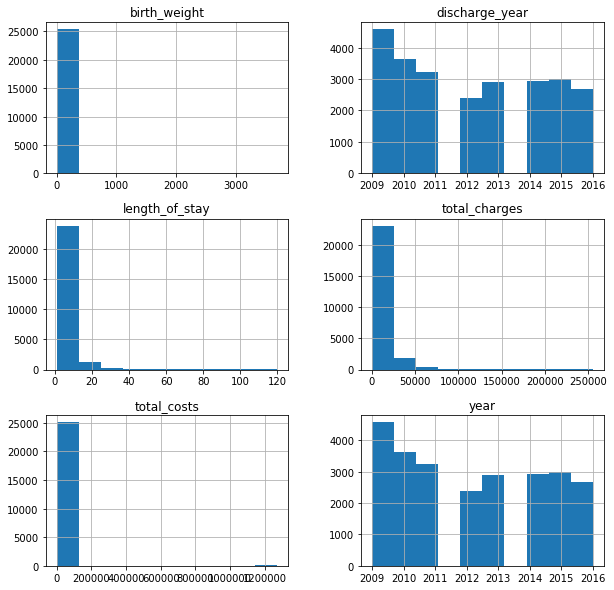

In [20]:
f_data.hist(figsize=[10,10])
plt.show()

### Processing Portion

In [21]:
cols = list(f_data)
cols2 = cols.copy()
pairwise_dfs = []
for col in cols:
    for col2 in cols2:
        if col != col2:
            tempDf = f_data[[col, col2]].dropna()
            if len(tempDf.index)>0:
                pairwise_dfs.append(tempDf)
    #if cols2.length > 0:
    cols2.remove(col)
len(pairwise_dfs)

946

In [22]:
significantAttr = pandas.DataFrame()
for df in pairwise_dfs:
    topValues = df.values[0]
    keys = list(df)
    if isinstance(topValues[0], Number) and isinstance(topValues[1], Number):
        x,y = df[keys[0]].to_numpy().reshape(-1,1),df[keys[1]].to_numpy()
        model = LinearRegression().fit(x,y)
        significantAttr=significantAttr.append(pandas.Series(['linear_regression',keys[0],keys[1],model.score(x,y)], index=['test','X','Y','R^2']), ignore_index=True)
    elif isinstance(topValues[0], str) and isinstance(topValues[1], str):
        chiTable = pandas.crosstab(df.iloc[:,0], df.iloc[:,1])
        chi2, p, dof, expected = chi2_contingency(chiTable.values)
        significantAttr=significantAttr.append(pandas.Series(['chi_squared',keys[0],keys[1],p], index=['test','X','Y','p']), ignore_index=True)
    elif isinstance(topValues[0], Number)  and (df[keys[1]].nunique() > 2):
        res = ols(keys[0] + ' ~ C('+ keys[1]+')', data=df).fit()
        anova_res = anova_lm(res, typ=2)
        sst = anova_res.at['C('+ keys[1]+')','sum_sq']
        ssr = anova_res.at['Residual','sum_sq']
        p = anova_res.at['C('+ keys[1]+')','PR(>F)']
        significantAttr=significantAttr.append(pandas.Series(['ANOVA',keys[0],keys[1],p,sst/(sst+ssr)], index=['test','X','Y','p','R^2']), ignore_index=True)
    elif isinstance(topValues[1], Number) and (df[keys[0]].nunique() > 2):
        res = ols(keys[1] + ' ~ C('+ keys[0]+')', data=df).fit()
        anova_res = anova_lm(res, typ=2)
        sst = anova_res.at['C('+ keys[0]+')','sum_sq']
        ssr = anova_res.at['Residual','sum_sq']
        p = anova_res.at['C('+ keys[0]+')','PR(>F)']
        significantAttr=significantAttr.append(pandas.Series(['ANOVA',keys[0],keys[1],p,sst/(sst+ssr)], index=['test','X','Y','p','R^2']), ignore_index=True)
    elif isinstance(topValues[0], Number):
        s1, s2 = df[(df[keys[1]]==topValues[1])][keys[0]], df[(df[keys[1]]!=topValues[1])][keys[0]]
        t, p = ttest_ind(s1, s2, equal_var=False)
        significantAttr=significantAttr.append(pandas.Series(['t_test',keys[0],keys[1],p], index=['test','X','Y','p']), ignore_index=True)
    elif isinstance(topValues[1], Number):
        s1, s2 = df[(df[keys[0]]==topValues[0])][keys[1]], df[(df[keys[0]]!=topValues[0])][keys[1]]
        t, p = ttest_ind(s1, s2, equal_var=False)
        significantAttr=significantAttr.append(pandas.Series(['t_test',keys[0],keys[1],p], index=['test','X','Y','p']), ignore_index=True)
    else:
        significantAttr=significantAttr.append(pandas.Series(['untested',keys[0],keys[1]], index=['test','X','Y']), ignore_index=True)
        # histogram
significantAttr.shape

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\base\model.py:1768: RuntimeWarning: invalid value encountered in true_divide
  F /= J
C:\Users\Michael\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Michael\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Michael\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not 

(946, 5)

In [33]:
significantAttr.groupby('test').count()
significantAttr.groupby('test').describe()

p                                          \
                   count      mean       std  min            25%   
test                                                               
ANOVA              165.0  0.072247  0.217879  0.0   0.000000e+00   
chi_squared        703.0  0.142707  0.342986  0.0   0.000000e+00   
linear_regression    0.0       NaN       NaN  NaN            NaN   
t_test              48.0  0.022594  0.092097  0.0  4.253709e-118   

                                                            R^2            \
                             50%           75%       max  count      mean   
test                                                                        
ANOVA              1.583737e-116  1.024336e-09  1.000000  165.0  0.130618   
chi_squared        4.726247e-123  1.593818e-09  1.000000    0.0       NaN   
linear_regression            NaN           NaN       NaN   15.0  0.107441   
t_test              1.666387e-22  1.532723e-04  0.514841    0.0       NaN   

                                                                             
                        std       min       25%       50%       75%     max  
test                                                                         
ANOVA              0.192291  0.000003  0.008449  0.032532  0.179290  0.8112  
chi_squared             NaN       NaN       NaN       NaN       NaN     NaN  
linear_regression  0.265066  0.000010  0.000402  0.009374  0.028706  1.0000  
t_test                  NaN       NaN       NaN       NaN       NaN     NaN

In [24]:
cols = list(f_data)
heat_df_RSq = pandas.DataFrame(index = cols, columns = cols)
heat_df_P = pandas.DataFrame(index = cols, columns = cols)
for col in cols:
    populate = False
    for col2 in cols:
        if populate:
            heat_df_RSq.at[col2,col] = significantAttr[((significantAttr['X']==col) & (significantAttr['Y']==col2))|((significantAttr['Y']==col) & (significantAttr['X']==col2))]['R^2'].values[0]
            heat_df_P.at[col2,col] = significantAttr[((significantAttr['X']==col) & (significantAttr['Y']==col2))|((significantAttr['Y']==col) & (significantAttr['X']==col2))]['p'].values[0]
        elif col2==col:
            populate = True
        if math.isnan(heat_df_RSq.at[col2, col]):
            heat_df_RSq.at[col2, col] = -1
        if math.isnan(heat_df_P.at[col2, col]):
            heat_df_P.at[col2, col] = -1

In [25]:
heat_df_RSq = heat_df_RSq.infer_objects()
heat_df_P = heat_df_P.infer_objects()

In [26]:
colorPalette =         ['#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff',
                        '#ffff00','#f2f20d','#e6e619','#d9d926','#cccc33','#bfbf40','#b2b24d','#a6a659','#999966',
                        '#8c8c73','#808080','#73738c','#666699','#5959a6','#4c4cb2','#4040bf','#3333cc','#2626d9',
                        '#1a1ae6','#0d0df2','#0000ff']
colorPaletteReversed = ['#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff','#ffffff',
                        '#0000ff','#0d0df2','#1a1ae6','#2626d9','#3333cc','#4040bf','#4c4cb2','#5959a6','#666699',
                        '#73738c','#808080','#8c8c73','#999966','#a6a659','#b2b24d','#bfbf40','#cccc33','#d9d926',
                        '#e6e619','#f2f20d','#ffff00']
seaborn.set(rc={'figure.figsize':(20,20)})

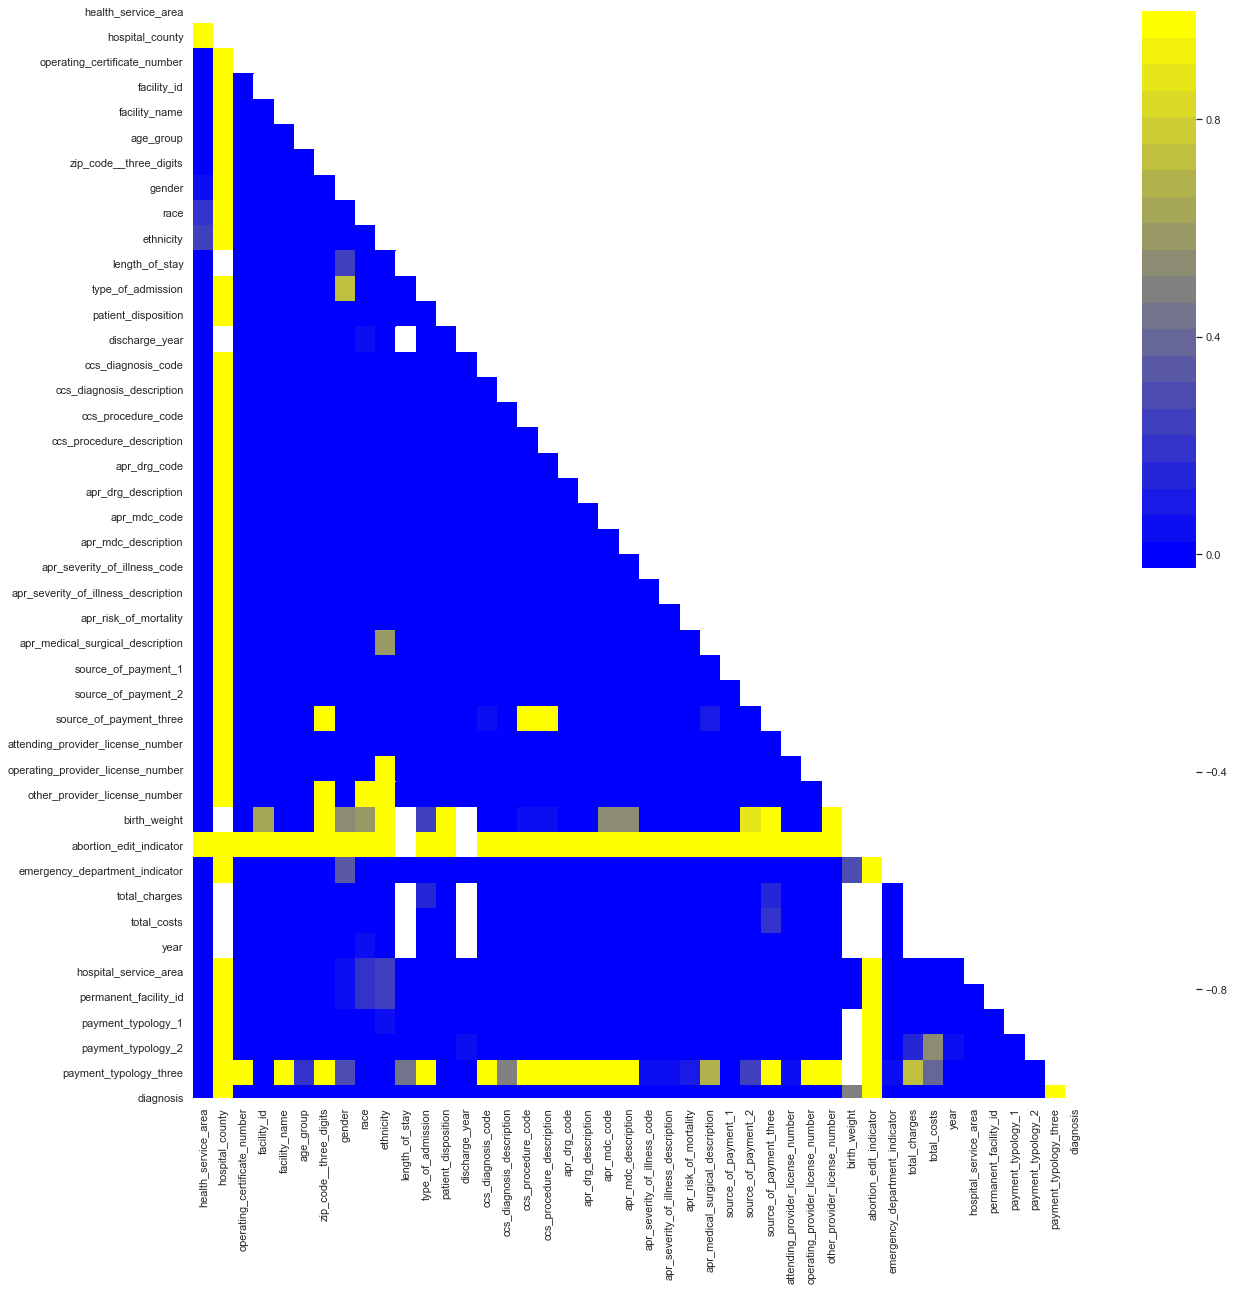

In [27]:
heatmap = seaborn.heatmap(heat_df_P, vmin=-1, vmax=1, cmap = colorPaletteReversed)

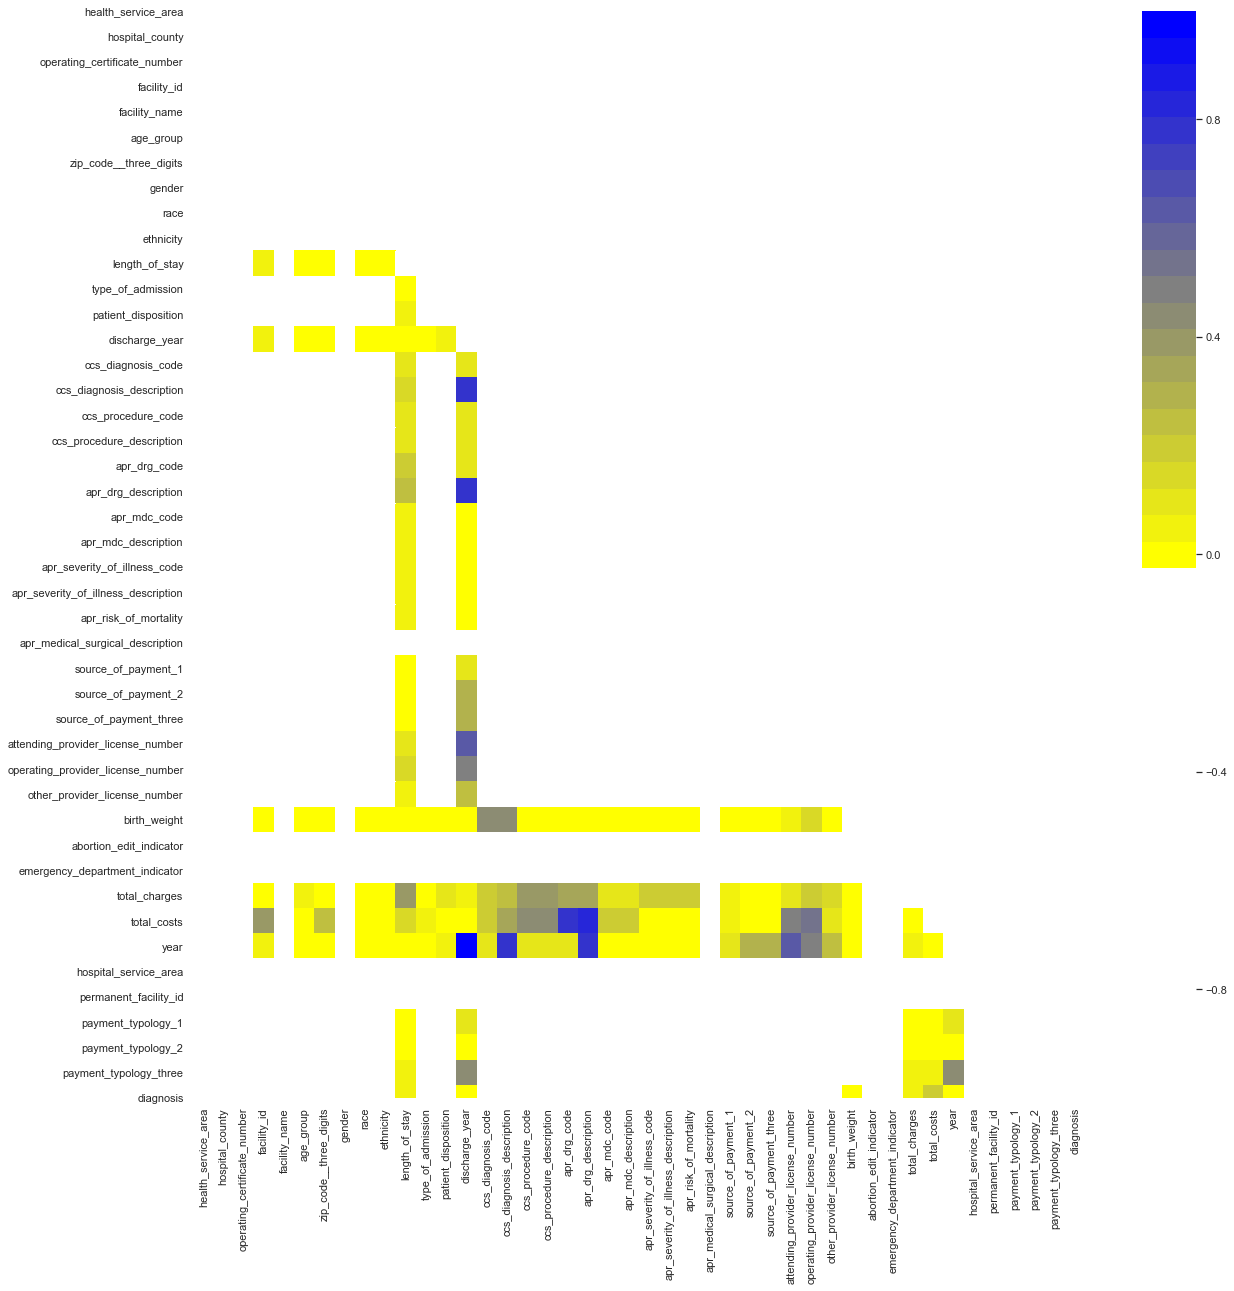

In [28]:
heatmap = seaborn.heatmap(heat_df_RSq, vmin=-1, vmax=1, cmap = colorPalette)

In [29]:
f_data[['gender','length_of_stay']].groupby('gender').mean()

,length_of_stay
gender,
F,5.286906
M,5.361693


In [30]:
f_data[['gender','length_of_stay']].groupby('gender').std()

,length_of_stay
gender,
F,4.705856
M,5.753084


In [31]:
heat_df_P.describe()

,health_service_area,hospital_county,operating_certificate_number,facility_id,facility_name,age_group,zip_code__three_digits,gender,race,ethnicity,...,emergency_department_indicator,total_charges,total_costs,year,hospital_service_area,permanent_facility_id,payment_typology_1,payment_typology_2,payment_typology_three,diagnosis
count,4.400000e+01,44.000000,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,...,44.000000,44.000000,44.000000,44.000000,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,44.000000,44.0
mean,3.341011e-02,0.636364,-2.361550e-02,-5.387864e-02,-6.907004e-02,-1.089261e-01,-4.614822e-02,-1.096306e-01,-1.338265e-01,-1.134983e-01,...,-0.794478,-0.844305,-0.842445,-0.862636,-8.863636e-01,-9.090909e-01,-9.318182e-01,-9.545455e-01,-0.954880,-1.0
std,2.661516e-01,0.780307,3.374453e-01,3.500279e-01,3.950570e-01,3.894211e-01,5.248739e-01,4.702285e-01,4.972741e-01,5.659982e-01,...,0.410027,0.408414,0.409807,0.349742,3.210382e-01,2.908034e-01,2.549717e-01,2.107071e-01,0.299291,0.0
min,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.0
25%,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.916131e-102,0.000000e+00,5.514875e-99,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.0
50%,9.725239e-45,1.000000,8.060084e-193,0.000000e+00,8.060084e-193,2.414765e-309,1.720466e-127,8.569317e-15,1.451487e-106,2.431478e-07,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.0
75%,1.920513e-09,1.000000,3.237457e-35,2.023460e-124,3.237457e-35,7.588661e-66,3.459432e-36,1.982859e-04,1.110217e-04,8.296780e-04,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.0
max,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.042958,0.722088,0.550749,0.044016,6.111000e-35,6.111000e-35,1.942906e-163,2.517169e-52,0.985271,-1.0
